ROOT: D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\korean_emotion_complex_vision_5_percent_verified_processed
TRAIN exists: True
Found images: 17975
D:/ex/최종프로젝트/AI_Dev_3rd_Project/YEO/datasets/korean_emotion_complex_vision_5_percent_verified_processed/train\기쁨\006b56dc2f8cda2361e1b01b2496d6f352dd5b1790f0a9b0bfcbe540b292247d_여_20_기쁨_공공시설&종교&의료시설_20210130213913-001-005.jpg
D:/ex/최종프로젝트/AI_Dev_3rd_Project/YEO/datasets/korean_emotion_complex_vision_5_percent_verified_processed/train\기쁨\006b56dc2f8cda2361e1b01b2496d6f352dd5b1790f0a9b0bfcbe540b292247d_여_20_기쁨_공공시설&종교&의료시설_20210130213913-001-006.jpg
D:/ex/최종프로젝트/AI_Dev_3rd_Project/YEO/datasets/korean_emotion_complex_vision_5_percent_verified_processed/train\기쁨\006b56dc2f8cda2361e1b01b2496d6f352dd5b1790f0a9b0bfcbe540b292247d_여_20_기쁨_도심 환경_20210130214044-008-002.jpg
[1000/17975] ok:1000 fail:0
[2000/17975] ok:2000 fail:0
[3000/17975] ok:3000 fail:0
[4000/17975] ok:4000 fail:0
[5000/17975] ok:5000 fail:0
[6000/17975] ok:6000 fail:0
[7000/17975]

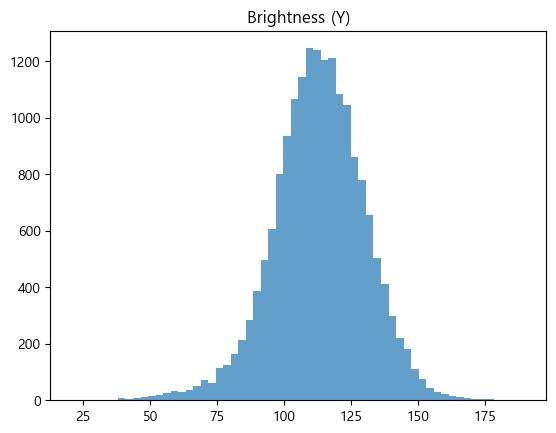

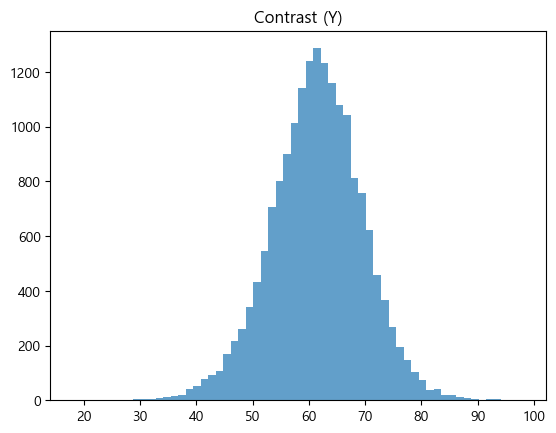

In [24]:
# 1) 경로 설정 (절대경로 고정)
from pathlib import Path
ROOT = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\korean_emotion_complex_vision_5_percent_verified_processed")
TRAIN = ROOT / "train"
print("ROOT:", ROOT)
print("TRAIN exists:", TRAIN.exists())

# 2) 유니코드/긴 경로(Windows) 안전 읽기
import numpy as np, cv2, os, sys

def to_long_path(p: Path) -> str:
    s = str(p)
    # Windows 긴 경로 프리픽스 붙이기 (이미 붙어있으면 그대로)
    if os.name == "nt" and not s.startswith("\\\\?\\"):
        # Path가 절대경로가 아니면 resolve()로 절대화
        s = str(p.resolve())
        if not s.startswith("\\\\?\\"):
            s = "\\\\?\\" + s
    return s

def imread_safe(p: Path):
    """윈도우 한글/긴 경로 안전 읽기. 실패 시 None."""
    # 1차: fromfile + imdecode (유니코드 강함)
    try:
        data = np.fromfile(to_long_path(p), dtype=np.uint8)
        if data.size > 0:
            img = cv2.imdecode(data, cv2.IMREAD_COLOR)
            if img is not None:
                return img
    except Exception:
        pass
    # 2차: 일반 imread (혹시 1차가 막히면)
    try:
        img = cv2.imread(str(p))
        return img
    except Exception:
        return None

# 3) 파일 수집 (rglob) — 출력은 보기 좋게
def list_images(base: Path, exts=(".jpg",".jpeg",".png",".bmp")):
    files = []
    for ext in exts:
        files.extend(base.rglob(f"*{ext}"))
    return files

files = list_images(TRAIN)
print("Found images:", len(files))
for p in files[:3]:
    rel_win = p.relative_to(TRAIN).as_posix().replace("/", "\\")
    print(f"{TRAIN.as_posix()}\\{rel_win}")

# 4) 밝기/대비 계산 유틸
def calc_brightness_contrast(img_bgr):
    y = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    return float(np.mean(y)), float(np.std(y))

# 5) 안전 루프 (중간 에러 무시하고 계속)
brightness, contrast = [], []
failed = []
for i, p in enumerate(files, 1):
    img = imread_safe(p)
    if img is None:
        failed.append(str(p))
        continue
    try:
        b, c = calc_brightness_contrast(img)
        brightness.append(b)
        contrast.append(c)
    except Exception as e:
        failed.append(f"{p} :: {e}")
    if i % 1000 == 0:
        print(f"[{i}/{len(files)}] ok:{len(brightness)} fail:{len(failed)}")

print("Done. OK:", len(brightness), "Fail:", len(failed))
if failed[:5]:
    print("Failed samples:")
    for f in failed[:5]:
        print(" -", f)

# 6) 히스토그램
import matplotlib.pyplot as plt
plt.figure(); plt.hist(brightness, bins=60, alpha=0.7); plt.title("Brightness (Y)")
plt.figure(); plt.hist(contrast,   bins=60, alpha=0.7); plt.title("Contrast (Y)")
plt.show()


검출이미지내에 밝기와 대비가 큰 격차가 있다. 전체적으로 색이 밋밋한 얼굴 이미지들이 있음으로, tail 부분을 clahe 등으로 조금 조정하면 성능 향상에 기여할 수 있을 것으로 가설을 설정